/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Training RNN without dropout...
Epoch [1/10], Loss: 0.7014
Epoch [2/10], Loss: 0.6948
Epoch [3/10], Loss: 0.6923
Epoch [4/10], Loss: 0.6886
Epoch [5/10], Loss: 0.6868
Epoch [6/10], Loss: 0.6858
Epoch [7/10], Loss: 0.6837
Epoch [8/10], Loss: 0.6821
Epoch [9/10], Loss: 0.6812
Epoch [10/10], Loss: 0.6790
Training RNN with dropout...
Epoch [1/10], Loss: 0.6981
Epoch [2/10], Loss: 0.6924
Epoch [3/10], Loss: 0.6898
Epoch [4/10], Loss: 0.6872
Epoch [5/10], Loss: 0.6851
Epoch [6/10], Loss: 0.6839
Epoch [7/10], Loss: 0.6822
Epoch [8/10], Loss: 0.6807
Epoch [9/10], Loss: 0.6791
Epoch [10/10], Loss: 0.6772


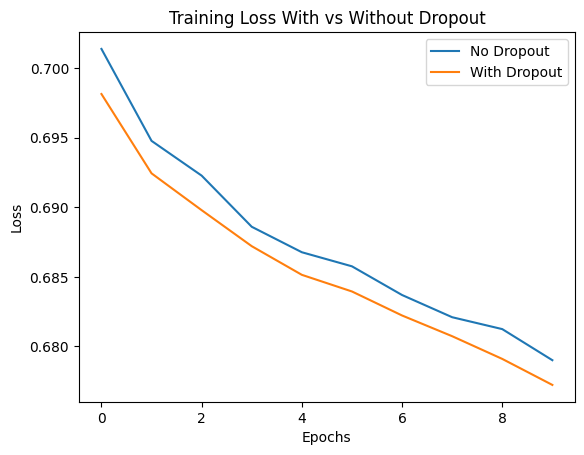

Training with batch size 16...
Epoch [1/10], Loss: 0.6982


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch [2/10], Loss: 0.6927
Epoch [3/10], Loss: 0.6896
Epoch [4/10], Loss: 0.6880
Epoch [5/10], Loss: 0.6849
Epoch [6/10], Loss: 0.6821
Epoch [7/10], Loss: 0.6801
Epoch [8/10], Loss: 0.6781
Epoch [9/10], Loss: 0.6785
Epoch [10/10], Loss: 0.6747
Training with batch size 64...
Epoch [1/10], Loss: 0.6948
Epoch [2/10], Loss: 0.6892
Epoch [3/10], Loss: 0.6864
Epoch [4/10], Loss: 0.6854
Epoch [5/10], Loss: 0.6828
Epoch [6/10], Loss: 0.6814
Epoch [7/10], Loss: 0.6805
Epoch [8/10], Loss: 0.6789
Epoch [9/10], Loss: 0.6773
Epoch [10/10], Loss: 0.6772
Training with batch size 256...
Epoch [1/10], Loss: 0.6974
Epoch [2/10], Loss: 0.6936
Epoch [3/10], Loss: 0.6920
Epoch [4/10], Loss: 0.6904
Epoch [5/10], Loss: 0.6893
Epoch [6/10], Loss: 0.6879
Epoch [7/10], Loss: 0.6870
Epoch [8/10], Loss: 0.6859
Epoch [9/10], Loss: 0.6848
Epoch [10/10], Loss: 0.6840


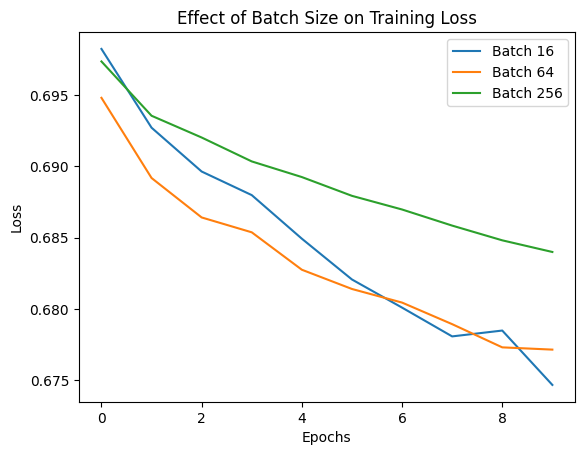

Visualizing hidden states...


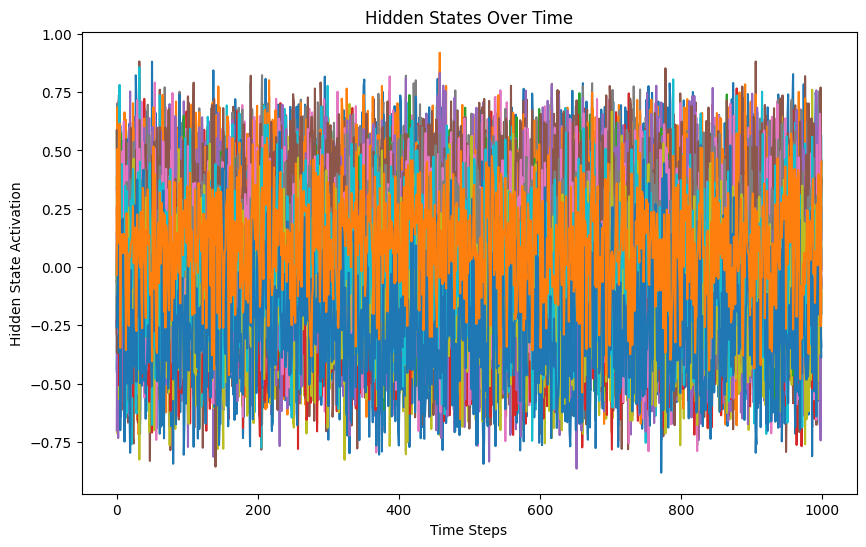

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Define RNN Model with optional Dropout
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])  # Taking the last output
        return out, hidden

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            hidden = torch.zeros(model.num_layers, inputs.size(0), model.hidden_size).to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs, hidden)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")
    return losses

# Function to visualize hidden states
def visualize_hidden_states(model, test_loader):
    model.eval()
    hidden_states = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            hidden = torch.zeros(model.num_layers, inputs.size(0), model.hidden_size).to(device)
            _, hidden = model(inputs, hidden)
            hidden_states.append(hidden.squeeze().cpu().numpy())
    hidden_states = np.vstack(hidden_states)
    plt.figure(figsize=(10, 6))
    plt.plot(hidden_states)
    plt.title("Hidden States Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Hidden State Activation")
    plt.show()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generating synthetic data
num_samples = 1000
sequence_length = 10
input_size = 5
hidden_size = 32
output_size = 1
batch_size = 64

X = torch.randn(num_samples, sequence_length, input_size)
y = torch.randint(0, 2, (num_samples, output_size), dtype=torch.float32)
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train models with and without dropout
model_no_dropout = RNNModel(input_size, hidden_size, output_size, dropout=0.0).to(device)
model_with_dropout = RNNModel(input_size, hidden_size, output_size, dropout=0.3).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer_no_dropout = optim.Adam(model_no_dropout.parameters(), lr=0.001)
optimizer_with_dropout = optim.Adam(model_with_dropout.parameters(), lr=0.001)

print("Training RNN without dropout...")
losses_no_dropout = train_model(model_no_dropout, train_loader, criterion, optimizer_no_dropout)
print("Training RNN with dropout...")
losses_with_dropout = train_model(model_with_dropout, train_loader, criterion, optimizer_with_dropout)

# Plot loss comparison
plt.plot(losses_no_dropout, label="No Dropout")
plt.plot(losses_with_dropout, label="With Dropout")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss With vs Without Dropout")
plt.show()

# Train with different batch sizes
batch_sizes = [16, 64, 256]
for b in batch_sizes:
    print(f"Training with batch size {b}...")
    train_loader = DataLoader(dataset, batch_size=b, shuffle=True)
    model = RNNModel(input_size, hidden_size, output_size, dropout=0.2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = train_model(model, train_loader, criterion, optimizer)
    plt.plot(losses, label=f"Batch {b}")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Effect of Batch Size on Training Loss")
plt.show()

# Visualizing hidden states
print("Visualizing hidden states...")
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
visualize_hidden_states(model_no_dropout, test_loader)
